In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from multiprocessing import cpu_count
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
from PIL import Image
import seaborn as sns
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D,AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
import glob
import sys
import cv2
import imageio
import joblib
import math
import warnings
import os
import torch
import imagehash

# Ignore Warnings
warnings.filterwarnings("ignore")

# Activate pandas progress apply bar
tqdm.pandas()

print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow keras version: {tf.keras.__version__}')
print(f'python version: P{sys.version}')

2022-12-04 01:11:41.494086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


tensorflow version: 2.4.1
tensorflow keras version: 2.4.0
python version: P3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


# Read Train Test

In [ ]:
############ start ##############

In [9]:
train_df = pd.read_csv('/kaggle/input/590-yolo/yolotrain.csv')

In [ ]:
train_df['label'].head(5)

In [10]:
train_df.drop(train_df[train_df.label == 'unknown'].index, inplace=True)

In [ ]:
len(train_df.loc[train_df['label'] == 'dog'])

In [ ]:
################## Regression ###################

In [11]:
# cat = 1, dog = 0
train_df['label'] = (train_df['label'] == 'cat').astype(int)

In [12]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
train_df['filename'] = train_df['Id']+'.jpg'
#train_df.drop('img_path', axis=1, inplace=True)
train_df.drop('Id', axis=1, inplace=True)
train_df.drop('file_path', axis=1, inplace=True)
train_df.drop('coords', axis=1, inplace=True)
train_df.drop('x_min', axis=1, inplace=True)
train_df.drop('x_max', axis=1, inplace=True)
train_df.drop('y_min', axis=1, inplace=True)
train_df.drop('y_max', axis=1, inplace=True)

In [14]:
#train_df.columns
len(train_df)

9884

In [15]:
cat_df = train_df.loc[train_df['label'] == 1]
dog_df = train_df.loc[train_df['label'] == 0]
cat_df.drop('label', axis=1, inplace=True)
dog_df.drop('label', axis=1, inplace=True)

In [ ]:
######################################################
################## ALL #######################

In [16]:
gen_kwargs = dict(
    dataframe=train_df,
    directory=Path('/kaggle/input/petfinder-pawpularity-score/train'), 
    x_col='filename',
    y_col='Pawpularity',
    batch_size=32,
    seed=619,
    shuffle=True,
    class_mode='raw',
    target_size=(224, 224)
)
datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
train_generator =  datagen.flow_from_dataframe(**gen_kwargs, subset="training")
valid_generator =  datagen.flow_from_dataframe(**gen_kwargs, subset="validation")

Found 7908 validated image filenames.
Found 1976 validated image filenames.


In [17]:
inputs = keras.Input(shape=(224, 224, 3))

X = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(X)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(X)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Flatten()(X)

X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)

X = Dense(128, activation='relu')(X)

X = Dense(64, activation='relu')(X)

X = Dense(16, activation='relu')(X)

#X = Dense(4, activation='relu')(X)

outputs = Dense(1)(X)

model = keras.Model(inputs=inputs, outputs=outputs)

2022-12-04 01:16:23.717605: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-04 01:16:23.722135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-04 01:16:23.840781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 01:16:23.841563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-12-04 01:16:23.841733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-0

In [18]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    #optimizer="rmsprop",
    #loss=MeanSquaredError(),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

In [19]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)]
)

2022-12-04 01:17:59.579884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-04 01:17:59.584094: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000144999 Hz


Epoch 1/10


2022-12-04 01:18:00.410863: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-04 01:18:01.860184: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-04 01:18:01.896199: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


248/248 [==============================] - 162s 617ms/step - loss: 639.9217 - root_mean_squared_error: 25.0216 - val_loss: 438.2961 - val_root_mean_squared_error: 20.9355
Epoch 2/10
248/248 [==============================] - 116s 470ms/step - loss: 442.5516 - root_mean_squared_error: 21.0343 - val_loss: 443.3703 - val_root_mean_squared_error: 21.0564
Epoch 3/10
248/248 [==============================] - 117s 471ms/step - loss: 463.7338 - root_mean_squared_error: 21.5322 - val_loss: 431.5254 - val_root_mean_squared_error: 20.7732
Epoch 4/10
248/248 [==============================] - 118s 474ms/step - loss: 450.4616 - root_mean_squared_error: 21.2190 - val_loss: 454.5130 - val_root_mean_squared_error: 21.3193
Epoch 5/10
248/248 [==============================] - 117s 472ms/step - loss: 450.3665 - root_mean_squared_error: 21.2199 - val_loss: 452.9936 - val_root_mean_squared_error: 21.2836
Epoch 6/10
248/248 [==============================] - 118s 476ms/step - loss: 452.2658 - root_mean_sq

In [29]:
history_dict = history.history

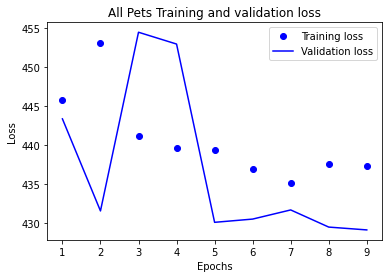

In [42]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.plot(range(1, len(loss_values)), loss_values[1:], 'bo', label='Training loss')
plt.plot(range(1, len(loss_values)), val_loss_values[1:], 'b', label='Validation loss')
plt.title('All Pets Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
df_test = pd.read_csv('/kaggle/input/590-yolo/yolov5.csv', index_col='Id')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test['filename'] = df_test.index
df_test.drop('true_label', axis=1, inplace=True)
df_test.drop('pred_label', axis=1, inplace=True)
df_test.drop('file_path', axis=1, inplace=True)


In [25]:
test_generator = datagen.flow_from_dataframe(dataframe=df_test,
                                             directory=Path('/kaggle/input/own-tests'), 
                                             x_col='filename',
                                             y_col=None,
                                             batch_size=32,
                                             seed=42,
                                             shuffle=False,
                                             class_mode=None,
                                             target_size=(224, 224)
                                            )

Found 29 validated image filenames.


In [26]:
yhat_test = model.predict(test_generator, verbose=1)

1/1 [==============================] - 2s 2s/step


In [43]:
frames = [
    pd.Series(df_test.index.values, name='Id'),
    pd.Series(yhat_test.ravel(), name='Pawpularity')
]
submission = pd.concat(frames, axis=1)
submission.head()
submission.sort_values(by=['Pawpularity'],ascending= False)
submission.to_csv("all_pets.csv", index=False)